<a href="https://colab.research.google.com/github/evysb/RL_in_stock_trading/blob/main/RL_in_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

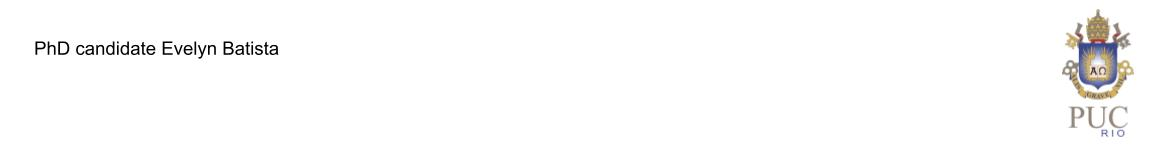

O material neste repositório são scripts do Professor Jones Granatyr modificador por mim.

## Instalar bibliotecas e montar drive do Google Drive

In [ ]:
!pip install pandas==1.3.3
!pip install pandas-datareader==0.10.0
!pip install yfinance
'''
CLICAR em restart runtime depois da instalação!!
'''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 11.2 MB/s eta 0:00:00
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 242.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

'\nCLICAR em restart runtime depois da instalação!!\n'

### Tem algumas explicações de RL em negociação de ações aqui:

https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/

Mas o código não é o mesmo!!

In [ ]:
# Montar drive no google drive!
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive'
os.chdir(workdir_path)
os.mkdir("models_rl")
os.chdir('/content/drive/My Drive/models_rl')

Mounted at /content/drive


FileExistsError: ignored

In [ ]:
os.chdir('/content/drive/My Drive/models_rl')

## Importar das bibliotecas

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader # usado para nao ter que baixar o csv
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yfin


yfin.pdr_override()

from tqdm import tqdm_notebook, tqdm
from collections import deque

<ipython-input-4-e7feebe2a320>:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
print("versão do TF ",tf.__version__)
print("versão do Pandas ",pd.__version__)
print("versão do pandas_datareader ", data_reader.__version__)

versão do TF  2.9.2
versão do Pandas  1.3.3
versão do pandas_datareader  0.10.0


## Criação das funções que usaremos para treinar o modelo

In [ ]:
class Agent():

  def __init__(self, state_size, action_space = 3, continue_training=False): 
    self.state_size = state_size #depende do tamanho da janela (window_size)
    self.action_space = action_space #acoes: compra, venda, faz nada
    self.memory = deque(maxlen = 2000)
    self.gamma = 0.95 #0.9
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
    self.model = self.get_model()
  
  '''
    Política
  '''
  def trade(self, state): #função que vai fazer a negociação, vai retornar as ações
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space) # no inicio será aleatório
    
    actions = self.model.predict(state) #depois usará as predição da rede
    return np.argmax(actions[0])
  
  '''
    Cria a rede e compila - pode mudar conforme o necessário
  '''
  def get_model(self):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units = 16, activation = "relu", input_dim = self.state_size))
    model.add(tf.keras.layers.Dense(units = 32, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = 64, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = self.action_space, activation = "linear"))
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(lr = 0.001))
    return model
  
  '''
    Treinamento da rede
  '''
  def train_on_batch(self, batch_size):
    batch = []
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)): #pega as ultimas transações da memória
      batch.append(self.memory[i])
      
    for state, action, reward, next_state, done in batch:
      if not done:
        #Faz previsoes para o próximo estado
        #self.model.predict(next_state)[0] -> valores de Q no estado next_state
        #np.amax(self.model.predict(next_state)[0]) #busca ql maior valor de Q(s,a), ou seja, ql maior R
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #Eq Bellman
        
      target = self.model.predict(state)
      target[0][action] = reward #associa a ação que levou a ter a reward calculada
      
      self.model.fit(state, target, epochs=3, verbose=0) #TODO mudar ep
      
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay
      

## Análise e pré-processamento da base de dados

#### Sigmoid

usado para normalizar entre 0 e 1

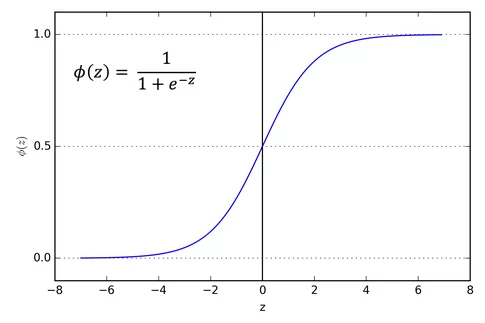

In [ ]:
def sigmoid(z):
  return 1 / (1 + math.exp(-z))

In [ ]:
sigmoid(0.5)

0.6224593312018546

#### Formatação de preços

verifica se está tendo lucro ou não e formata (deixa bonitinho)

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
stocks_price_format(100)

'$ 100.000000'

#### Análise e criação da função de carregar a base de dados

In [ ]:
from datetime import datetime
startdate = datetime(2016,12,1)
enddate = datetime(2022,12,15)
dataset_total = pdr.get_data_yahoo("AAPL", start=startdate, end=enddate)

[*********************100%***********************]  1 of 1 completed


In [ ]:
#pega só 1000 dados para treino e teste
dataset = dataset_total[:1000]
dataset_test = dataset_total[1000:]

In [ ]:
'''
Quais dados temos:
Date - data
High - maior preço foi vendido no dia
Low - menor preço foi vendido no dia
Open - valor de abertura, qto que a ação valia no inicio do dia
Close	- valor de fechamento,  qto que a ação foi vendida no final do dia
Volume - volume de ações que foram transacionadas nesse dia
Adj Close - qto que valeria a ação considerando dividendos e outros fatores

****AGORA so vamos utilizar apenas o close
'''
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-01,27.592501,27.735001,27.257500,27.372499,25.616566,148347600
2016-12-02,27.292500,27.522499,27.212500,27.475000,25.712486,106112000
2016-12-05,27.500000,27.507500,27.062500,27.277500,25.527657,137298000
2016-12-06,27.375000,27.590000,27.297501,27.487499,25.724182,104782000
2016-12-07,27.315001,27.797501,27.290001,27.757500,25.976864,119994800


In [ ]:
str(dataset.index[0]).split()[0]

'2016-10-07'

In [ ]:
dataset.index[-1]

Timestamp('2020-09-28 00:00:00')

In [ ]:
dataset['Close']

Date
2016-10-07     28.514999
2016-10-10     29.012501
2016-10-11     29.075001
2016-10-12     29.334999
2016-10-13     29.245001
                 ...    
2020-09-22    111.809998
2020-09-23    107.120003
2020-09-24    108.220001
2020-09-25    112.279999
2020-09-28    114.959999
Name: Close, Length: 1000, dtype: float64

In [ ]:
def dataset_loader(dataset):
  #TODO pegar outros além do Close
  close = dataset['Close']
  return close

### Criador de estados - com janelamento

In [ ]:
0 - 5 + 1

-4

In [ ]:
20 - 5 + 1

16

In [ ]:
dataset[16:21]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-31,28.557501,28.299999,28.412500,28.385000,105677600.0,26.620600
2016-11-01,28.442499,27.632500,28.365000,27.872499,175303200.0,26.139957
2016-11-02,28.087500,27.807501,27.850000,27.897499,113326800.0,26.163404
2016-11-03,27.865000,27.387501,27.745001,27.457500,107730400.0,25.882967
2016-11-04,27.562500,27.027500,27.132500,27.209999,123348000.0,25.649656


In [ ]:
#vai fazer D - D' para capturar a tendencia, se sobe ou não o número
#se identifica que a tendencia é subir o preço, o agente nao vai comprar

'''
        state                       target
[30.2 , 32.4 , [...], 40.7 , 53.5] [46.1]
subtraindo...
32.4 - 30.2 = 2.2
32.4 - ... = ...
53.5 - 40.7 = 12.8
'''

def state_creator(data, timestep, window_size): 
  starting_id = timestep - window_size + 1 # da onde vai começar a pegar os dados na base
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep + 1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep + 1]) #vai repetir os valores de starting_id for negativo
    
  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i + 1] - windowed_data[i])) #normaliza dos dados e os subtrai
    
  return np.array([state]), windowed_data

### Loading da base de dados

In [ ]:
data = dataset_loader(dataset) #LEMBRANDO: so tem close!

In [ ]:
data_test = dataset_loader(dataset_test) #so tem close!

In [ ]:
s, w = state_creator(data, 0, 5)

In [ ]:
s

array([[0.5, 0.5, 0.5, 0.5]])

In [ ]:
w

[27.372499465942383,
 27.372499465942383,
 27.372499465942383,
 27.372499465942383,
 27.372499465942383]

## Fase de Treinamento:

### Configuração dos hyper parâmetros

In [ ]:
window_size = 10 #com 10 numeros, quer prever se compra ou nao
episodes = 1 #AUMENTAR
batch_size = 32
data_samples = len(data) - 1
data_samples_test = len(data_test) - 1

### Modelo

In [ ]:
agent = Agent(window_size)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,027
Trainable params: 3,027
Non-trainable params: 0
_________________________________________________________________


### Treinamento:

In [ ]:
for episode in range(1, episodes + 1):
  print("Episode: {}/{}".format(episode, episodes))
  state = state_creator(data, 0, window_size + 1)[0]
  total_profit = 0
  agent.inventory = []
  for t in tqdm(range(data_samples)):
    action = agent.trade(state)
    next_state = state_creator(data, t + 1, window_size + 1)[0]
    reward = 0
    
    if action == 1: # Comprando uma ação
      agent.inventory.append(data[t])
      print("Agent bought: ", stocks_price_format(data[t]))
    elif action == 2 and len(agent.inventory) > 0: # Vendendo uma ação, dado que so posso vender se ja comprei algo!
      buy_price = agent.inventory.pop(0) #remove 1 item da pilha e pega o preço que foi pago
      
      reward = max(data[t] - buy_price, 0) #valor atual da ação - valor pago #MAX pra não deixar recompensa negativa! (Pode ser modificado!)
      total_profit += data[t] - buy_price
      print("Agent sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price))
      
    if t == data_samples - 1:
      done = True
    else:
      done = False
      
    agent.memory.append((state, action, reward, next_state, done))
    
    state = next_state
    
    if done:
      print("######## DONE ########")
      print("-- [INFO] Total profit: ", total_profit)
      
    if len(agent.memory) > batch_size:
      agent.train_on_batch(batch_size)
     
  #if episode % 10 == 0:
  agent.model.save("model_{}.h5".format(episode)) #Salvando arquitetura e pesos!
    

Episode: 1/1


  0%|          | 0/999 [00:00<?, ?it/s]

Agent bought:  $ 27.475000
Agent bought:  $ 28.030001
Agent bought:  $ 28.325001
Agent bought:  $ 28.797501
Agent sold:  $ 28.797501  Profit: $ 1.322500
Agent sold:  $ 28.992500  Profit: $ 0.962500
Agent bought:  $ 29.264999
Agent sold:  $ 29.072500  Profit: $ 0.747499
Agent sold:  $ 29.129999  Profit: $ 0.332499
Agent bought:  $ 29.190001
Agent bought:  $ 29.182501
Agent sold:  $ 28.955000  Profit: - $ 0.309999
Agent bought:  $ 29.152500
Agent bought:  $ 29.777500
Agent sold:  $ 29.937500  Profit: $ 0.747499
Agent bought:  $ 29.760000
Agent sold:  $ 29.997499  Profit: $ 0.814999
Agent sold:  $ 29.945000  Profit: $ 0.792500
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 33/999 [00:06<03:09,  5.10it/s]

Agent sold:  $ 30.000000  Profit: $ 0.222500
1/1 [==============================] - 0s 12ms/step


  3%|▎         | 34/999 [00:10<05:32,  2.90it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 34/999 [00:10<05:11,  3.10it/s]


KeyboardInterrupt: ignored

# Inferência

In [ ]:
model = tf.keras.models.load_model("model_1.h5")

In [ ]:
for t in tqdm(range(data_samples_test)):
  state = state_creator(data_test, t + 1, window_size + 1)[0]
  print(state)
  action = model.predict(state)
  result = np.argmax(action[0])
  print("result ", result)
  
  if result == 1:
    print("-- [INFO] bought!")
  elif result == 2:
    print("-- [INFO] sold!")
  else:
    print("-- [INFO] do nothing!")
  print('\n')
  print('-----------------------------')
  print('\n')

  0%|          | 0/519 [00:00<?, ?it/s]

[[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.02959817]]
1/1 [==============================] - 0s 44ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.02959817 0.78918166]]
1/1 [==============================] - 0s 13ms/step


  0%|          | 2/519 [00:00<00:33, 15.54it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.02959817 0.78918166 0.70266078]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.5
  0.02959817 0.78918166 0.70266078 0.63645198]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.02959817
  0.78918166 0.70266078 0.63645198 0.92129015]]
1/1 [==============================] - 0s 13ms/step


  1%|          | 5/519 [00:00<00:25, 20.32it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.5        0.02959817 0.78918166
  0.70266078 0.63645198 0.92129015 0.97515641]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.02959817 0.78918166 0.70266078
  0.63645198 0.92129015 0.97515641 0.58904058]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.5        0.5        0.02959817 0.78918166 0.70266078 0.63645198
  0.92129015 0.97515641 0.58904058 0.46505721]]
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 8/519 [00:00<00:22, 22.22it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.02959817 0.78918166 0.70266078 0.63645198 0.92129015
  0.97515641 0.58904058 0.46505721 0.33403253]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.02959817 0.78918166 0.70266078 0.63645198 0.92129015 0.97515641
  0.58904058 0.46505721 0.33403253 0.81757448]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.78918166 0.70266078 0.63645198 0.92129015 0.97515641 0.58904058
  0.46505721 0.33403253 0.81757448 0.65248884]]
1/1 [==============================] - 0s 12ms/step


  2%|▏         | 11/519 [00:00<00:23, 22.06it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.70266078 0.63645198 0.92129015 0.97515641 0.58904058 0.46505721
  0.33403253 0.81757448 0.65248884 0.06913852]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.63645198 0.92129015 0.97515641 0.58904058 0.46505721 0.33403253
  0.81757448 0.65248884 0.06913852 0.81153253]]
1/1 [==============================] - 0s 12ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.92129015 0.97515641 0.58904058 0.46505721 0.33403253 0.81757448
  0.65248884 0.06913852 0.81153253 0.3036463 ]]
1/1 [==============================] - 0s 12ms/step


  3%|▎         | 14/519 [00:00<00:22, 22.66it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.97515641 0.58904058 0.46505721 0.33403253 0.81757448 0.65248884
  0.06913852 0.81153253 0.3036463  0.34750943]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.58904058 0.46505721 0.33403253 0.81757448 0.65248884 0.06913852
  0.81153253 0.3036463  0.34750943 0.99776215]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.46505721 0.33403253 0.81757448 0.65248884 0.06913852 0.81153253
  0.3036463  0.34750943 0.99776215 0.48250722]]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 17/519 [00:00<00:22, 22.58it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.33403253 0.81757448 0.65248884 0.06913852 0.81153253 0.3036463
  0.34750943 0.99776215 0.48250722 0.70889005]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.81757448 0.65248884 0.06913852 0.81153253 0.3036463  0.34750943
  0.99776215 0.48250722 0.70889005 0.11506742]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.65248884 0.06913852 0.81153253 0.3036463  0.34750943 0.99776215
  0.48250722 0.70889005 0.11506742 0.82778248]]
1/1 [==============================] - 0s 13ms/step


  4%|▍         | 20/519 [00:00<00:21, 22.83it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.06913852 0.81153253 0.3036463  0.34750943 0.99776215 0.48250722
  0.70889005 0.11506742 0.82778248 0.97466752]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.81153253 0.3036463  0.34750943 0.99776215 0.48250722 0.70889005
  0.11506742 0.82778248 0.97466752 0.28495827]]
1/1 [==============================] - 0s 15ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.3036463  0.34750943 0.99776215 0.48250722 0.70889005 0.11506742
  0.82778248 0.97466752 0.28495827 0.73301907]]
1/1 [==============================] - 0s 13ms/step


  4%|▍         | 23/519 [00:01<00:21, 23.16it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.34750943 0.99776215 0.48250722 0.70889005 0.11506742 0.82778248
  0.97466752 0.28495827 0.73301907 0.99116361]]
1/1 [==============================] - 0s 15ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.99776215 0.48250722 0.70889005 0.11506742 0.82778248 0.97466752
  0.28495827 0.73301907 0.99116361 0.13943299]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.48250722 0.70889005 0.11506742 0.82778248 0.97466752 0.28495827
  0.73301907 0.99116361 0.13943299 0.2404902 ]]
1/1 [==============================] - 0s 13ms/step


  5%|▌         | 26/519 [00:01<00:21, 23.08it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.70889005 0.11506742 0.82778248 0.97466752 0.28495827 0.73301907
  0.99116361 0.13943299 0.2404902  0.26308434]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.11506742 0.82778248 0.97466752 0.28495827 0.73301907 0.99116361
  0.13943299 0.2404902  0.26308434 0.03626376]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.82778248 0.97466752 0.28495827 0.73301907 0.99116361 0.13943299
  0.2404902  0.26308434 0.03626376 0.83201711]]
1/1 [==============================] - 0s 15ms/step


  6%|▌         | 29/519 [00:01<00:21, 23.00it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.97466752 0.28495827 0.73301907 0.99116361 0.13943299 0.2404902
  0.26308434 0.03626376 0.83201711 0.01200925]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.28495827 0.73301907 0.99116361 0.13943299 0.2404902  0.26308434
  0.03626376 0.83201711 0.01200925 0.98687468]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.73301907 0.99116361 0.13943299 0.2404902  0.26308434 0.03626376
  0.83201711 0.01200925 0.98687468 0.7558398 ]]
1/1 [==============================] - 0s 15ms/step


  6%|▌         | 32/519 [00:01<00:21, 23.04it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.99116361 0.13943299 0.2404902  0.26308434 0.03626376 0.83201711
  0.01200925 0.98687468 0.7558398  0.04436152]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.13943299 0.2404902  0.26308434 0.03626376 0.83201711 0.01200925
  0.98687468 0.7558398  0.04436152 0.45512292]]
1/1 [==============================] - 0s 15ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.2404902  0.26308434 0.03626376 0.83201711 0.01200925 0.98687468
  0.7558398  0.04436152 0.45512292 0.88992707]]
1/1 [==============================] - 0s 13ms/step


  7%|▋         | 35/519 [00:01<00:21, 22.83it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.26308434 0.03626376 0.83201711 0.01200925 0.98687468 0.7558398
  0.04436152 0.45512292 0.88992707 0.12131929]]
1/1 [==============================] - 0s 12ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.03626376 0.83201711 0.01200925 0.98687468 0.7558398  0.04436152
  0.45512292 0.88992707 0.12131929 0.1455418 ]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.83201711 0.01200925 0.98687468 0.7558398  0.04436152 0.45512292
  0.88992707 0.12131929 0.1455418  0.66596747]]
1/1 [==============================] - 0s 13ms/step


  7%|▋         | 38/519 [00:01<00:20, 23.11it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.01200925 0.98687468 0.7558398  0.04436152 0.45512292 0.88992707
  0.12131929 0.1455418  0.66596747 0.98522592]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.98687468 0.7558398  0.04436152 0.45512292 0.88992707 0.12131929
  0.1455418  0.66596747 0.98522592 0.99215495]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.7558398  0.04436152 0.45512292 0.88992707 0.12131929 0.1455418
  0.66596747 0.98522592 0.99215495 0.90025061]]
1/1 [==============================] - 0s 13ms/step


  8%|▊         | 41/519 [00:01<00:20, 23.51it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.04436152 0.45512292 0.88992707 0.12131929 0.1455418  0.66596747
  0.98522592 0.99215495 0.90025061 0.97916347]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.45512292 0.88992707 0.12131929 0.1455418  0.66596747 0.98522592
  0.99215495 0.90025061 0.97916347 0.559715  ]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.88992707 0.12131929 0.1455418  0.66596747 0.98522592 0.99215495
  0.90025061 0.97916347 0.559715   0.24973875]]
1/1 [==============================] - 0s 12ms/step


  8%|▊         | 44/519 [00:01<00:19, 23.95it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.12131929 0.1455418  0.66596747 0.98522592 0.99215495 0.90025061
  0.97916347 0.559715   0.24973875 0.00689526]]
1/1 [==============================] - 0s 12ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.1455418  0.66596747 0.98522592 0.99215495 0.90025061 0.97916347
  0.559715   0.24973875 0.00689526 0.00588182]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.66596747 0.98522592 0.99215495 0.90025061 0.97916347 0.559715
  0.24973875 0.00689526 0.00588182 0.8984384 ]]
1/1 [==============================] - 0s 14ms/step


  9%|▉         | 47/519 [00:02<00:19, 23.62it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.98522592 0.99215495 0.90025061 0.97916347 0.559715   0.24973875
  0.00689526 0.00588182 0.8984384  0.70056842]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.99215495 0.90025061 0.97916347 0.559715   0.24973875 0.00689526
  0.00588182 0.8984384  0.70056842 0.25922451]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.90025061 0.97916347 0.559715   0.24973875 0.00689526 0.00588182
  0.8984384  0.70056842 0.25922451 0.96923105]]
1/1 [==============================] - 0s 14ms/step


 10%|▉         | 50/519 [00:02<00:19, 23.74it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.97916347 0.559715   0.24973875 0.00689526 0.00588182 0.8984384
  0.70056842 0.25922451 0.96923105 0.34750943]]
1/1 [==============================] - 0s 15ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.559715   0.24973875 0.00689526 0.00588182 0.8984384  0.70056842
  0.25922451 0.96923105 0.34750943 0.53743212]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.24973875 0.00689526 0.00588182 0.8984384  0.70056842 0.25922451
  0.96923105 0.34750943 0.53743212 0.28904862]]
1/1 [==============================] - 0s 15ms/step


 10%|█         | 53/519 [00:02<00:19, 23.49it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.00689526 0.00588182 0.8984384  0.70056842 0.25922451 0.96923105
  0.34750943 0.53743212 0.28904862 0.34978256]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.00588182 0.8984384  0.70056842 0.25922451 0.96923105 0.34750943
  0.53743212 0.28904862 0.34978256 0.43536506]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.8984384  0.70056842 0.25922451 0.96923105 0.34750943 0.53743212
  0.28904862 0.34978256 0.43536506 0.55971124]]
1/1 [==============================] - 0s 13ms/step


 11%|█         | 56/519 [00:02<00:20, 23.03it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.70056842 0.25922451 0.96923105 0.34750943 0.53743212 0.28904862
  0.34978256 0.43536506 0.55971124 0.1015616 ]]
1/1 [==============================] - 0s 12ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.25922451 0.96923105 0.34750943 0.53743212 0.28904862 0.34978256
  0.43536506 0.55971124 0.1015616  0.08706529]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.96923105 0.34750943 0.53743212 0.28904862 0.34978256 0.43536506
  0.55971124 0.1015616  0.08706529 0.24416302]]
1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 59/519 [00:02<00:19, 23.11it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.34750943 0.53743212 0.28904862 0.34978256 0.43536506 0.55971124
  0.1015616  0.08706529 0.24416302 0.539912  ]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.53743212 0.28904862 0.34978256 0.43536506 0.55971124 0.1015616
  0.08706529 0.24416302 0.539912   0.02043229]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.28904862 0.34978256 0.43536506 0.55971124 0.1015616  0.08706529
  0.24416302 0.539912   0.02043229 0.46505721]]
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 62/519 [00:02<00:19, 22.92it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.34978256 0.43536506 0.55971124 0.1015616  0.08706529 0.24416302
  0.539912   0.02043229 0.46505721 0.37519302]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.43536506 0.55971124 0.1015616  0.08706529 0.24416302 0.539912
  0.02043229 0.46505721 0.37519302 0.01261715]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.55971124 0.1015616  0.08706529 0.24416302 0.539912   0.02043229
  0.46505721 0.37519302 0.01261715 0.56709395]]
1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 65/519 [00:02<00:19, 23.07it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.1015616  0.08706529 0.24416302 0.539912   0.02043229 0.46505721
  0.37519302 0.01261715 0.56709395 0.99854312]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.08706529 0.24416302 0.539912   0.02043229 0.46505721 0.37519302
  0.01261715 0.56709395 0.99854312 0.06476708]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.24416302 0.539912   0.02043229 0.46505721 0.37519302 0.01261715
  0.56709395 0.99854312 0.06476708 0.04478748]]
1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 68/519 [00:02<00:19, 22.96it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.539912   0.02043229 0.46505721 0.37519302 0.01261715 0.56709395
  0.99854312 0.06476708 0.04478748 0.12675055]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.02043229 0.46505721 0.37519302 0.01261715 0.56709395 0.99854312
  0.06476708 0.04478748 0.12675055 0.78414734]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.46505721 0.37519302 0.01261715 0.56709395 0.99854312 0.06476708
  0.04478748 0.12675055 0.78414734 0.00630556]]
1/1 [==============================] - 0s 14ms/step


 14%|█▎        | 71/519 [00:03<00:19, 23.21it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.37519302 0.01261715 0.56709395 0.99854312 0.06476708 0.04478748
  0.12675055 0.78414734 0.00630556 0.99125072]]
1/1 [==============================] - 0s 16ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.01261715 0.56709395 0.99854312 0.06476708 0.04478748 0.12675055
  0.78414734 0.00630556 0.99125072 0.2478722 ]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.56709395 0.99854312 0.06476708 0.04478748 0.12675055 0.78414734
  0.00630556 0.99125072 0.2478722  0.87868071]]
1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 74/519 [00:03<00:19, 23.28it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.99854312 0.06476708 0.04478748 0.12675055 0.78414734 0.00630556
  0.99125072 0.2478722  0.87868071 0.28292465]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.06476708 0.04478748 0.12675055 0.78414734 0.00630556 0.99125072
  0.2478722  0.87868071 0.28292465 0.95073395]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.04478748 0.12675055 0.78414734 0.00630556 0.99125072 0.2478722
  0.87868071 0.28292465 0.95073395 0.82920478]]
1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 77/519 [00:03<00:19, 22.25it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.12675055 0.78414734 0.00630556 0.99125072 0.2478722  0.87868071
  0.28292465 0.95073395 0.82920478 0.30789102]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.78414734 0.00630556 0.99125072 0.2478722  0.87868071 0.28292465
  0.95073395 0.82920478 0.30789102 0.01434361]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.00630556 0.99125072 0.2478722  0.87868071 0.28292465 0.95073395
  0.82920478 0.30789102 0.01434361 0.36818737]]
1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 80/519 [00:03<00:19, 22.60it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.99125072 0.2478722  0.87868071 0.28292465 0.95073395 0.82920478
  0.30789102 0.01434361 0.36818737 0.96770458]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.2478722  0.87868071 0.28292465 0.95073395 0.82920478 0.30789102
  0.01434361 0.36818737 0.96770458 0.29943318]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.87868071 0.28292465 0.95073395 0.82920478 0.30789102 0.01434361
  0.36818737 0.96770458 0.29943318 0.07943821]]
1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 83/519 [00:03<00:19, 22.67it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.28292465 0.95073395 0.82920478 0.30789102 0.01434361 0.36818737
  0.96770458 0.29943318 0.07943821 0.62245933]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.95073395 0.82920478 0.30789102 0.01434361 0.36818737 0.96770458
  0.29943318 0.07943821 0.62245933 0.65021917]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.82920478 0.30789102 0.01434361 0.36818737 0.96770458 0.29943318
  0.07943821 0.62245933 0.65021917 0.54487897]]
1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 86/519 [00:03<00:19, 22.68it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.30789102 0.01434361 0.36818737 0.96770458 0.29943318 0.07943821
  0.62245933 0.65021917 0.54487897 0.18392205]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.01434361 0.36818737 0.96770458 0.29943318 0.07943821 0.62245933
  0.65021917 0.54487897 0.18392205 0.90465054]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.36818737 0.96770458 0.29943318 0.07943821 0.62245933 0.65021917
  0.54487897 0.18392205 0.90465054 0.70056682]]
1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 89/519 [00:03<00:18, 22.86it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.96770458 0.29943318 0.07943821 0.62245933 0.65021917 0.54487897
  0.18392205 0.90465054 0.70056682 0.94784651]]
1/1 [==============================] - 0s 12ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.29943318 0.07943821 0.62245933 0.65021917 0.54487897 0.18392205
  0.90465054 0.70056682 0.94784651 0.57688467]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.07943821 0.62245933 0.65021917 0.54487897 0.18392205 0.90465054
  0.70056682 0.94784651 0.57688467 0.84422448]]
1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 92/519 [00:04<00:18, 23.12it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.62245933 0.65021917 0.54487897 0.18392205 0.90465054 0.70056682
  0.94784651 0.57688467 0.84422448 0.9212896 ]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.65021917 0.54487897 0.18392205 0.90465054 0.70056682 0.94784651
  0.57688467 0.84422448 0.9212896  0.93339193]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.54487897 0.18392205 0.90465054 0.70056682 0.94784651 0.57688467
  0.84422448 0.9212896  0.93339193 0.14679103]]
1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 95/519 [00:04<00:18, 23.49it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.18392205 0.90465054 0.70056682 0.94784651 0.57688467 0.84422448
  0.9212896  0.93339193 0.14679103 0.96045573]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.90465054 0.70056682 0.94784651 0.57688467 0.84422448 0.9212896
  0.93339193 0.14679103 0.96045573 0.08317316]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.70056682 0.94784651 0.57688467 0.84422448 0.9212896  0.93339193
  0.14679103 0.96045573 0.08317316 0.92201185]]
1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 98/519 [00:04<00:18, 23.31it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.94784651 0.57688467 0.84422448 0.9212896  0.93339193 0.14679103
  0.96045573 0.08317316 0.92201185 0.41581037]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.57688467 0.84422448 0.9212896  0.93339193 0.14679103 0.96045573
  0.08317316 0.92201185 0.41581037 0.66373706]]
1/1 [==============================] - 0s 14ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.84422448 0.9212896  0.93339193 0.14679103 0.96045573 0.08317316
  0.92201185 0.41581037 0.66373706 0.15058813]]
1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 101/519 [00:04<00:18, 23.00it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.9212896  0.93339193 0.14679103 0.96045573 0.08317316 0.92201185
  0.41581037 0.66373706 0.15058813 0.59628255]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.93339193 0.14679103 0.96045573 0.08317316 0.92201185 0.41581037
  0.66373706 0.15058813 0.59628255 0.173647  ]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.14679103 0.96045573 0.08317316 0.92201185 0.41581037 0.66373706
  0.15058813 0.59628255 0.173647   0.91528981]]
1/1 [==============================] - 0s 12ms/step


 20%|██        | 104/519 [00:04<00:17, 23.12it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.96045573 0.08317316 0.92201185 0.41581037 0.66373706 0.15058813
  0.59628255 0.173647   0.91528981 0.59868619]]
1/1 [==============================] - 0s 15ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.08317316 0.92201185 0.41581037 0.66373706 0.15058813 0.59628255
  0.173647   0.91528981 0.59868619 0.41824018]]
1/1 [==============================] - 0s 12ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.92201185 0.41581037 0.66373706 0.15058813 0.59628255 0.173647
  0.91528981 0.59868619 0.41824018 0.30789102]]
1/1 [==============================] - 0s 14ms/step


 21%|██        | 107/519 [00:04<00:17, 23.04it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.41581037 0.66373706 0.15058813 0.59628255 0.173647   0.91528981
  0.59868619 0.41824018 0.30789102 0.47501929]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.66373706 0.15058813 0.59628255 0.173647   0.91528981 0.59868619
  0.41824018 0.30789102 0.47501929 0.11712013]]
1/1 [==============================] - 0s 16ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.15058813 0.59628255 0.173647   0.91528981 0.59868619 0.41824018
  0.30789102 0.47501929 0.11712013 0.74649144]]
1/1 [==============================] - 0s 15ms/step


 21%|██        | 110/519 [00:04<00:18, 22.49it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.59628255 0.173647   0.91528981 0.59868619 0.41824018 0.30789102
  0.47501929 0.11712013 0.74649144 0.00910311]]
1/1 [==============================] - 0s 14ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.173647   0.91528981 0.59868619 0.41824018 0.30789102 0.47501929
  0.11712013 0.74649144 0.00910311 0.56217838]]
1/1 [==============================] - 0s 13ms/step
result  1
-- [INFO] bought!


-----------------------------


[[0.91528981 0.59868619 0.41824018 0.30789102 0.47501929 0.11712013
  0.74649144 0.00910311 0.56217838 0.83753485]]
1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 113/519 [00:04<00:17, 22.84it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.59868619 0.41824018 0.30789102 0.47501929 0.11712013 0.74649144
  0.00910311 0.56217838 0.83753485 0.61538405]]
1/1 [==============================] - 0s 13ms/step
result  2
-- [INFO] sold!


-----------------------------


[[0.41824018 0.30789102 0.47501929 0.11712013 0.74649144 0.00910311
  0.56217838 0.83753485 0.61538405 0.03356896]]
1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 114/519 [00:05<00:17, 22.70it/s]


KeyboardInterrupt: ignored